# Bitcoin Wallet Key and Address Generation

This notebook demonstrates how to generate a BIP-39 seed phrase, derive Bitcoin keys, and generate different types of Bitcoin addresses.

- [Setup](#Setup)
- [Seed Phrase](#Seed-Phrase)
- [Binary Seed](#Binary-Seed)
- [Master Private Key](#Master-Private-Key)
- [Extended Private Key](#Extended-Private-Key)
- [Generate Child Keys](#Generate-Child-Keys)
- [Bitcoin Addresses](#Bitcoin-Addresses)

# Setup

- Import Libraries

In [1]:
from mnemonic import Mnemonic
from bip32utils import BIP32Key
import hashlib
import base58
import qrcode
from IPython.display import display
from qrcode.image.pil import PilImage

- Prevent saving logs and checkpoints locally

In [2]:
%config NotebookNotary.db_file = ':memory:'

In [3]:
%autosave 0

Autosave disabled


## Seed Phrase 
- And Validation

In [4]:
def generate_valid_seed_phrase():
    """
    Generate a valid BIP-39 seed phrase.
    
    Returns:
        str: A valid 12-word BIP-39 seed phrase.
    """
    mnemo = Mnemonic("english")
    seed_phrase = mnemo.generate(strength=128)  # Generates a 12-word seed phrase
    return seed_phrase


In [5]:
def validate_seed_phrase(seed_phrase):
    """
    Validate a BIP-39 seed phrase for correct word count, valid words, and checksum.
    
    Args:
        seed_phrase (str): The BIP-39 seed phrase to validate.
    
    Returns:
        None: If the seed phrase is valid.
    
    Raises:
        ValueError: If the seed phrase is invalid.
    """
    mnemo = Mnemonic("english")
    seed_words = seed_phrase.split()

    # Step 1: Validate word count (must be 12, 15, 18, 21, or 24)
    valid_word_counts = [12, 15, 18, 21, 24]
    if len(seed_words) not in valid_word_counts:
        raise ValueError(f"Invalid word count. Seed phrase must be one of the following word counts: {valid_word_counts}.")
    
    # Step 2: Validate each word in the seed phrase is a valid BIP-39 word
    bip39_wordlist = mnemo.wordlist
    invalid_words = [word for word in seed_words if word not in bip39_wordlist]
    
    if invalid_words:
        raise ValueError(f"Invalid words in seed phrase: {', '.join(invalid_words)}. Ensure all words are valid BIP-39 words.")
    
    # Step 3: Validate the checksum
    if not mnemo.check(seed_phrase):
        raise ValueError("Invalid BIP-39 seed phrase. Checksum does not match.")
    
    # If all checks pass, print a success message
    print("Seed phrase is valid!")

In [6]:
seed_phrase = generate_valid_seed_phrase()
passphrase = ""  # Optional passphrase (can be left blank)
print(f"\033[31mSeed: {seed_phrase}\033[0m\n")
validate_seed_phrase(seed_phrase)

Seed: disorder piece fetch inflict rib liquid mistake betray skill beauty wheel resource

Seed phrase is valid!


## Binary Seed

In [7]:
mnemo = Mnemonic("english")
binary_seed = mnemo.to_seed(seed_phrase)
print("Binary Seed:", binary_seed, "\n")
print("Binary Seed (hex):", binary_seed.hex(), "\n")

Binary Seed: b'~J\xba\x0f\xb9\xb5\xf0\xcfZ\xf5\xf1\xe3\xc9\xf1\x9b\xe962\x12\xd5,m\x08\xc2\x14\x0b\x86n\xe2_G\x1ac\xff\xb5U\ns\x90\xb5\xb7\t\x12\x8f\xd4\xc5\xb7S\xc7\xb2\xd6y\xd6\xec\xcf[\xf6\x9c\x8a\x82\\S\x9di' 

Binary Seed (hex): 7e4aba0fb9b5f0cf5af5f1e3c9f19be9363212d52c6d08c2140b866ee25f471a63ffb5550a7390b5b709128fd4c5b753c7b2d679d6eccf5bf69c8a825c539d69 



## Master Private Key 
- and Chain Code

In [8]:
master_key = BIP32Key.fromEntropy(binary_seed)
print("Master Private Key (WIF):", master_key.WalletImportFormat(), "\n")
print("Master Chain Code (hex):", master_key.ChainCode().hex(), "\n")

Master Private Key (WIF): KxmdNZYDymmA68JhJjEKbzwdg4FMTFfCdcRp1ZqwDNbNrSxUcvD3 

Master Chain Code (hex): 8db61bd3ea66337419f8e68e8a95b50bd68853e2b476ae7f8773328b3ac8fbce 



## Extended Private Key 
- Denoted as xPrv

In [9]:
print("Extended Private Key (xPrv):", master_key.ExtendedKey(private=True), "\n")

Extended Private Key (xPrv): xprv9s21ZrQH143K3UBsyuNFxJbRzhKokTPhSjZZr3prPUDWbQuQxEj3hVzr182UDvM5sJ755PV65ejm8ohEBHVxFYaTedfuQCK3A1G4rGN4ubz 



## Generate Child Keys
- Private/Public Keys

########################################################################
Child Key 1 (Private): L2roxHVPhkuEQTEYr4dcN7XJVtcCUhsvzJMqngXG1RWCutaUpGPA


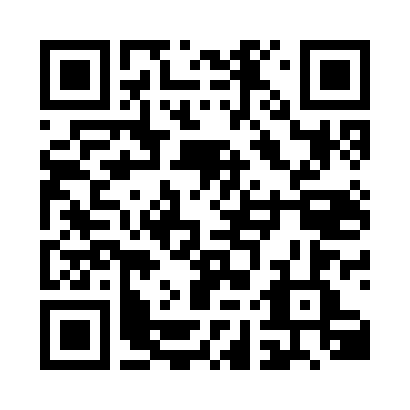

Child Key 1 (Public): 029bc879888d77dca457db693f57bd92b8cf9aedfb2d5f7a58f025b735356ace78


In [10]:
num_children = 1
child_keys = {}
for i in range(num_children):
    child_key = master_key.ChildKey(i)
    child_keys[i] = {
        "private_key": child_key.WalletImportFormat(),
        "public_key": child_key.PublicKey().hex()
    }

for index, keys in child_keys.items():
    print("########################################################################")
    print(f"Child Key {index + 1} (Private): {keys['private_key']}")
    qr = qrcode.make(keys['private_key'], image_factory=PilImage)
    display(qr)  # Display the QR code image inline
    print(f"Child Key {index + 1} (Public): {keys['public_key']}")

## Bitcoin Addresses

In [11]:
def hash160(data):
    sha256 = hashlib.sha256(data).digest()
    ripemd160 = hashlib.new('ripemd160')
    ripemd160.update(sha256)
    return ripemd160.digest()

def checksum(data):
    return hashlib.sha256(hashlib.sha256(data).digest()).digest()[:4]

def public_key_to_p2pkh_address(public_key):
    prefix = b'\x00'
    pubkey_hash = hash160(public_key)
    address = prefix + pubkey_hash
    return base58.b58encode(address + checksum(address)).decode()

def public_key_to_p2sh_p2wpkh_address(public_key):
    prefix = b'\x05'
    witness_program = b'\x00\x14' + hash160(public_key)
    address = prefix + hash160(witness_program)
    return base58.b58encode(address + checksum(address)).decode()

def public_key_to_bech32_address(public_key):
    import bech32
    witness_program = hash160(public_key)
    return bech32.encode("bc", 0, witness_program)

########################################################################


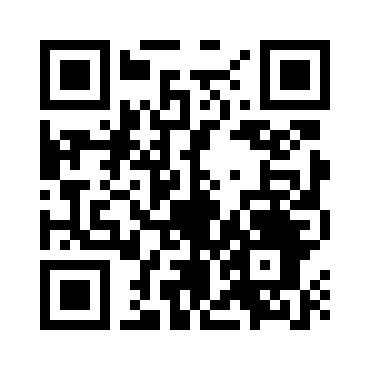

Child Key 1 Addresses:
  P2PKH Address (Legacy): 1Fx1bYfuVmS3m2jZKszY2NDFuKNRVFnGit
  P2SH-P2WPKH Address (Nested SegWit): 3GTG3gDGXkLJyeYceeVgqEedyVVehQ6opU
  Bech32 Address (Native SegWit): bc1q50uj94vwxmrdk70803u6uwz8c8gvrs8j0gqky7



In [12]:
for index, keys in child_keys.items():
    public_key_bytes = bytes.fromhex(keys['public_key'])
    p2pkh_address = public_key_to_p2pkh_address(public_key_bytes)
    p2sh_p2wpkh_address = public_key_to_p2sh_p2wpkh_address(public_key_bytes)
    bech32_address = public_key_to_bech32_address(public_key_bytes)

    print("########################################################################")
    qr = qrcode.make(bech32_address, image_factory=PilImage)
    display(qr)  # Display the QR code image inline
    print(f"Child Key {index + 1} Addresses:")
    print(f"  P2PKH Address (Legacy): {p2pkh_address}")
    print(f"  P2SH-P2WPKH Address (Nested SegWit): {p2sh_p2wpkh_address}")
    print(f"  Bech32 Address (Native SegWit): {bech32_address}")
    print()